In [1]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
zoom = '7'
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + zoom + '.zarr'

ds2d = xr.open_zarr(file)


In [3]:
tas_um = ds2d['tas'] #temperature near surface
tas_um_month = tas_um.groupby("time.month").mean() # Calculate monthly mean.


In [4]:
file_era5 = '/g/data/rt52/era5/single-levels/reanalysis/2t/2020/2t_era5_oper_sfc_*.nc'

tas_era = xr.open_mfdataset(file_era5, combine = 'nested', concat_dim = 'time')
tas_era_monthly = tas_era['t2m'].groupby('time.month').mean() # Calculate monthly mean.

In [5]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )

In [8]:
# tas_era_monthly_aus = tas_era_monthly.sel(longitude = slice(149, 152), latitude = slice(-32.8, -34.8))
tas_era_monthly_aus = tas_era_monthly.sel(longitude = slice(65, 100), latitude = slice(40, 5))

In [9]:

# longitudes and latitudes for the ERA5 grid
lon = tas_era_monthly_aus['longitude'].values
lat = tas_era_monthly_aus['latitude'].values

# nside for um simulation, it should be equal to 2**zoom
this_nside = hp.get_nside(tas_um_month)

cells = get_nn_lon_lat_index(this_nside, lon, lat) 

cells

<xarray.DataArray (lat: 141, lon: 141)> Size: 159kB
array([[ 6470,  6468,  6468, ..., 27205, 26863, 26863],
       [ 6465,  6468,  6468, ..., 26862, 26863, 26863],
       [ 6465,  6465,  5102, ..., 26862, 26862, 26861],
       ...,
       [93361, 93364, 93364, ..., 88990, 88991, 88989],
       [93361, 93339, 93339, ..., 88990, 88988, 88989],
       [93338, 93339, 93339, ..., 88985, 88988, 88988]], shape=(141, 141))
Coordinates:
  * lat      (lat) float32 564B 40.0 39.75 39.5 39.25 39.0 ... 5.75 5.5 5.25 5.0
  * lon      (lon) float32 564B 65.0 65.25 65.5 65.75 ... 99.25 99.5 99.75 100.0

Text(0.5, 1.0, 'UM surface temperature for February 2020')

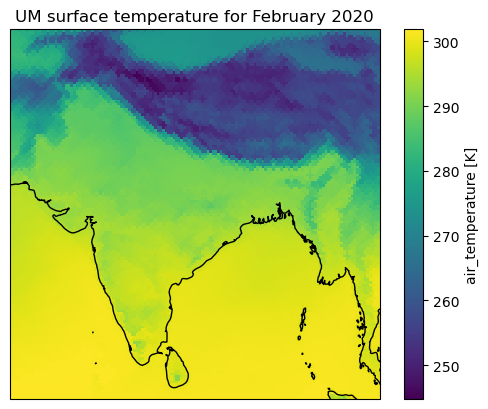

In [10]:
projection = ccrs.PlateCarree(central_longitude = 0.0)

# Plot UM simulation regrided to lon/lat from ERA5.
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
tas_um_month.isel(cell = cells).sel(month = 2).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM surface temperature for February 2020')

# selcting domain and precipitation

In [24]:
file =  '/g/data/qx55/germany_node/d3hp003.zarr/P1D_mean_z10_atm.zarr'

data = xr.open_zarr(file)

In [25]:
for name, var in data.data_vars.items():
    ln = var.attrs.get('long_name', None)
    print(f"{name:<8} → long_name: {ln}")


clivi    → long_name: cloud ice path
clt      → long_name: total cloud cover
clwvi    → long_name: cloud condensed water path
egpvi    → long_name: Atmosphere Geopotential Energy Content
einvi    → long_name: Atmosphere Moist Internal Energy Content
ekhvi    → long_name: Atmosphere Horizontal Kinetic Energy Content
ekvvi    → long_name: Atmosphere Vertical Kinetic Energy Content
hflsd    → long_name: latent heat flux
hfssd    → long_name: sensible heat flux
hur      → long_name: relative humidity
hus      → long_name: Specific humidity
huss     → long_name: specific humidity in 2m
mrso     → long_name: Water content of soil layers
o3vi     → long_name: ozone path
orog     → long_name: surface altitude
pr       → long_name: precipitation flux
prs      → long_name: large-scale precipitation flux (snow)
prw      → long_name: water vapor path
ps       → long_name: surface pressure
psl      → long_name: mean sea level pressure
qall     → long_name: mass fraction of all hydrometeors in air
r

In [13]:
ppt = data['pr']*86400

In [14]:
# sm = data['mrso']  # (time, cell)
# # sm_sum = sm.sum(dim='soil_level')
# sm_sum = sm.isel(soil_level=slice(0, 2)).sum(dim='soil_level')

In [16]:
unique_cell_ids = np.unique(cells.values)  # unique cell IDs to select

subset_pr = ppt.sel(cell=unique_cell_ids)
# subset_sm = sm_sum.sel(cell=unique_cell_ids)

In [18]:
subset_pr

<xarray.DataArray 'pr' (time: 425, cell: 5502)> Size: 9MB
dask.array<getitem, shape=(425, 5502), dtype=float32, chunksize=(4, 5502), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2020-01-02 2020-01-03 ... 2021-03-01
Dimensions without coordinates: cell

IndexError: vindex key has entries out of bounds for indexing along axis 1 of size 5502: array([[ 6470,  6468,  6468, ..., 27205, 26863, 26863],
       [ 6465,  6468,  6468, ..., 26862, 26863, 26863],
       [ 6465,  6465,  5102, ..., 26862, 26862, 26861],
       ...,
       [93361, 93364, 93364, ..., 88990, 88991, 88989],
       [93361, 93339, 93339, ..., 88990, 88988, 88989],
       [93338, 93339, 93339, ..., 88985, 88988, 88988]], shape=(141, 141))

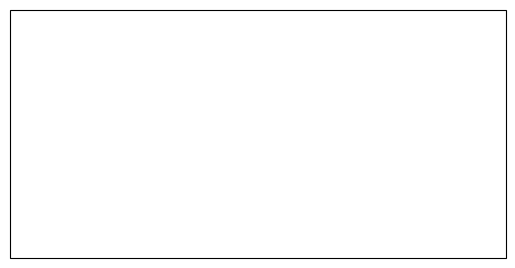

In [21]:
projection = ccrs.PlateCarree(central_longitude = 0.0)

# Plot UM simulation regrided to lon/lat from ERA5.
fig, ax = plt.subplots(subplot_kw = {"projection": projection})
subset_pr.isel(cell = cells).sel(time = 2).plot(cmap = 'viridis', transform = ccrs.PlateCarree())
ax.coastlines()
ax.set_title('UM surface temperature for February 2020')

NameError: name 'pr_plot' is not defined

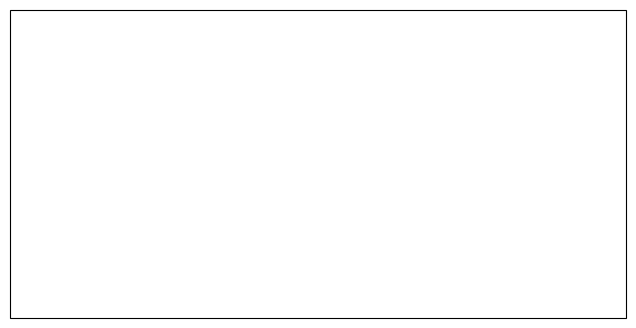

In [19]:
projection = ccrs.PlateCarree(central_longitude=0.0)
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={"projection": projection})

# xarray’s .plot knows to use the 'lon' and 'lat' coords
pr_plot.plot(ax=ax,
             x='lon', y='lat',
             cmap='viridis',
             transform=ccrs.PlateCarree(),
             cbar_kwargs={'label': 'Precipitation (mm/day)'})

ax.coastlines()
ax.set_title(f"Precipitation on {str(t0)[:10]}")
plt.show()

In [17]:
# sm_pos = subset_sm#.where(subset_pr > 0)
# pr_pos = subset_pr.where(subset_pr > 0.2)

# # Step 1: Compute 95th percentile for each cell along time
# sm_95 = sm_pos.quantile(0.95, dim='time')
# pr_95 = pr_pos.quantile(0.95, dim='time')

# # Step 2: Create boolean masks of time points where values exceed the 95th percentile
# sm_mask = sm_pos > sm_95
# pr_mask = pr_pos > pr_95

In [ ]:
# Step 3: Logical AND — only where both exceed the threshold
joint_mask = sm_mask & pr_mask

# Step 4: Apply mask to get actual values
sm_exceed = subset_sm.where(joint_mask)
pr_exceed = subset_pr.where(joint_mask)

# Step 5: Flatten and drop NaNs
sm_values = sm_exceed.values.flatten()
pr_values = pr_exceed.values.flatten()

# Drop NaNs (non-joint-exceedance points)
valid = (~np.isnan(sm_values)) & (~np.isnan(pr_values))
sm_clean = sm_values[valid]
pr_clean = pr_values[valid]

# Step 6: Scatter plot
plt.figure(figsize=(7, 6))
plt.scatter(sm_clean, pr_clean, alpha=1, s=4, color='blue')
plt.xlabel("Soil Moisture (mrso) > 95th percentile")
plt.ylabel("Precipitation (pr) > 95th percentile")
plt.title("Scatter of Joint High SM and PR Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# cape

In [ ]:
file =  '/g/data/qx55/germany_node/d3hp003.zarr/PT1H_point_z10_atm.zarr'

data = xr.open_zarr(file)

In [ ]:
data